# Salary Prediction Model - Evaluation & Analysis

This notebook provides comprehensive evaluation of the trained salary prediction model, including:
- Performance metrics (Train vs Test comparison)
- Overfitting/Underfitting analysis
- Error analysis
- Visualizations
- Detailed breakdown of where the model makes mistakes

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Setup complete!")

Setup complete!


## 2. Load Model and Preprocessing Objects

In [2]:
print("Loading model and preprocessing objects...")
model = joblib.load('../backend/model.pkl')
scaler = joblib.load('../backend/scaler.pkl')
label_encoder = joblib.load('../backend/label_encoder.pkl')
feature_columns = joblib.load('../backend/feature_columns.pkl')

print(f"Model type: {type(model).__name__}")
print(f"Number of features: {len(feature_columns)}")
print("Model loaded successfully!")

Loading model and preprocessing objects...
Model type: CatBoostClassifier
Number of features: 97
Model loaded successfully!


## 3. Load and Prepare Test Data

In [3]:
# Load data
df = pd.read_csv('../data/train.csv')

# Use last 20% as test set
test_size = int(len(df) * 0.2)
test_df = df.tail(test_size).copy()

print(f"Total dataset size: {len(df):,}")
print(f"Test set size: {len(test_df):,}")
print(f"\nTest set class distribution:")
print(test_df['income_>50K'].value_counts())
print(f"\nPositive class ratio: {test_df['income_>50K'].mean()*100:.2f}%")

Total dataset size: 43,957
Test set size: 8,791

Test set class distribution:
income_>50K
0    6667
1    2124
Name: count, dtype: int64

Positive class ratio: 24.16%


In [4]:
# Separate features and target
y_test = test_df['income_>50K'].values
X_test = test_df.drop(columns=['income_>50K', 'fnlwgt']).copy()

print("Original test features:")
print(X_test.head())

Original test features:
       age         workclass     education  educational-num  \
35166   48           Private       HS-grad                9   
35167   41  Self-emp-not-inc       HS-grad                9   
35168   44           Private    Assoc-acdm               12   
35169   42           Private       HS-grad                9   
35170   23           Private  Some-college               10   

           marital-status       occupation   relationship   race  gender  \
35166             Widowed    Other-service      Unmarried  White  Female   
35167  Married-civ-spouse  Exec-managerial        Husband  White    Male   
35168            Divorced  Exec-managerial  Not-in-family  White    Male   
35169  Married-civ-spouse    Other-service           Wife  Black  Female   
35170       Never-married            Sales  Not-in-family  White    Male   

       capital-gain  capital-loss  hours-per-week native-country  
35166             0             0              25  United-States  
35167 

## 4. Preprocess Test Data

In [5]:
# Apply same preprocessing as training
print("Preprocessing test data...")

# Label encode gender
X_test['gender'] = label_encoder.transform(X_test['gender'])

# One-hot encode categorical features
X_test = pd.get_dummies(X_test, columns=[
    'workclass', 'education', 'marital-status',
    'occupation', 'race', 'relationship', 'native-country'
], drop_first=True)

# Scale numeric features
num_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Align with training features
for col in feature_columns:
    if col not in X_test.columns:
        X_test[col] = 0

X_test = X_test[feature_columns]

print(f"Preprocessed shape: {X_test.shape}")
print("Preprocessing complete!")

Preprocessing test data...
Preprocessed shape: (8791, 97)
Preprocessing complete!


## 5. Make Predictions

In [6]:
# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Apply threshold (0.46 as used in production)
y_pred = (y_pred_proba >= 0.46).astype(int)

print(f"Predictions made: {len(y_pred):,}")
print(f"Predicted positive class: {y_pred.sum():,} ({y_pred.mean()*100:.2f}%)")
print(f"\nProbability statistics:")
print(f"  Min:  {y_pred_proba.min():.4f}")
print(f"  Max:  {y_pred_proba.max():.4f}")
print(f"  Mean: {y_pred_proba.mean():.4f}")
print(f"  Std:  {y_pred_proba.std():.4f}")

Predictions made: 8,791
Predicted positive class: 2,021 (22.99%)

Probability statistics:
  Min:  0.0001
  Max:  0.9994
  Mean: 0.2529
  Std:  0.3114


## 6. Overall Performance Metrics

In [7]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 70)
print("OVERALL MODEL PERFORMANCE")
print("=" * 70)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Store in dataframe for visualization
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc]
})

metrics_df

OVERALL MODEL PERFORMANCE
Accuracy:  0.8757 (87.57%)
Precision: 0.7551 (75.51%)
Recall:    0.7185 (71.85%)
F1 Score:  0.7363
ROC-AUC:   0.9319


,Metric,Score
0,Accuracy,0.875668
1,Precision,0.755072
2,Recall,0.718456
3,F1 Score,0.736309
4,ROC-AUC,0.931885


## 7. Train vs Test Metrics Comparison (Overfitting/Underfitting Analysis)

In [8]:
# Load and prepare training data (first 80% of dataset)
train_size = len(df) - test_size
train_df = df.head(train_size).copy()

print(f"Loading training data...")
print(f"Training set size: {len(train_df):,}")
print(f"Test set size: {len(test_df):,}")

# Separate features and target for training data
y_train = train_df['income_>50K'].values
X_train = train_df.drop(columns=['income_>50K', 'fnlwgt']).copy()

# Preprocess training data (same as test data)
X_train['gender'] = label_encoder.transform(X_train['gender'])
X_train = pd.get_dummies(X_train, columns=[
    'workclass', 'education', 'marital-status',
    'occupation', 'race', 'relationship', 'native-country'
], drop_first=True)
X_train[num_cols] = scaler.transform(X_train[num_cols])

# Align with training features
for col in feature_columns:
    if col not in X_train.columns:
        X_train[col] = 0
X_train = X_train[feature_columns]

# Make predictions on training data
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_pred_proba >= 0.46).astype(int)

# Calculate training metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)

print(f"\nTraining predictions complete!")
print(f"Training set predicted positive class: {y_train_pred.sum():,} ({y_train_pred.mean()*100:.2f}%)")

Loading training data...
Training set size: 35,166
Test set size: 8,791

Training predictions complete!
Training set predicted positive class: 8,053 (22.90%)


In [9]:
## 7.1. Multi-Model F1 Score Comparison (Overfitting Analysis)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import time

print("Training and evaluating multiple models...")
print("=" * 80)

# Store results
models_comparison = []

# 1. CatBoost (already trained)
print("\n1. CatBoost (existing model)")
catboost_train_f1 = train_f1
catboost_test_f1 = f1
models_comparison.append({
    'Model': 'CatBoost',
    'Train F1': catboost_train_f1,
    'Test F1': catboost_test_f1,
    'Gap': catboost_train_f1 - catboost_test_f1
})
print(f"   Train F1: {catboost_train_f1:.4f}")
print(f"   Test F1:  {catboost_test_f1:.4f}")

# 2. K-Nearest Neighbors
print("\n2. K-Nearest Neighbors (k=5)")
start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_train_pred = knn_model.predict(X_train)
knn_test_pred = knn_model.predict(X_test)
knn_train_f1 = f1_score(y_train, knn_train_pred)
knn_test_f1 = f1_score(y_test, knn_test_pred)
models_comparison.append({
    'Model': 'KNN',
    'Train F1': knn_train_f1,
    'Test F1': knn_test_f1,
    'Gap': knn_train_f1 - knn_test_f1
})
print(f"   Train F1: {knn_train_f1:.4f}")
print(f"   Test F1:  {knn_test_f1:.4f}")
print(f"   Training time:  {time.time() - start_time:.2f}s")

# 3. Decision Tree
print("\n3. Decision Tree")
start_time = time.time()
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)
dt_train_f1 = f1_score(y_train, dt_train_pred)
dt_test_f1 = f1_score(y_test, dt_test_pred)
models_comparison.append({
    'Model': 'Decision Tree',
    'Train F1': dt_train_f1,
    'Test F1': dt_test_f1,
    'Gap': dt_train_f1 - dt_test_f1
})
print(f"   Train F1: {dt_train_f1:.4f}")
print(f"   Test F1:  {dt_test_f1:.4f}")
print(f"   Training time:  {time.time() - start_time:.2f}s")

# 4. Naive Bayes
print("\n4. Naive Bayes (Gaussian)")
start_time = time.time()
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_train_pred = nb_model.predict(X_train)
nb_test_pred = nb_model.predict(X_test)
nb_train_f1 = f1_score(y_train, nb_train_pred)
nb_test_f1 = f1_score(y_test, nb_test_pred)
models_comparison.append({
    'Model': 'Naive Bayes',
    'Train F1': nb_train_f1,
    'Test F1': nb_test_f1,
    'Gap': nb_train_f1 - nb_test_f1
})
print(f"   Train F1: {nb_train_f1:.4f}")
print(f"   Test F1:  {nb_test_f1:.4f}")
print(f"   Training time:  {time.time() - start_time:.2f}s")

# 5. Logistic Regression
print("\n5. Logistic Regression")
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
lr_train_f1 = f1_score(y_train, lr_train_pred)
lr_test_f1 = f1_score(y_test, lr_test_pred)
models_comparison.append({
    'Model': 'Logistic Regression',
    'Train F1': lr_train_f1,
    'Test F1': lr_test_f1,
    'Gap': lr_train_f1 - lr_test_f1
})
print(f"   Train F1: {lr_train_f1:.4f}")
print(f"   Test F1:  {lr_test_f1:.4f}")
print(f"   Training time:  {time.time() - start_time:.2f}s")

print("\n" + "=" * 80)
print("All models trained successfully!")

# Create comparison dataframe
models_df = pd.DataFrame(models_comparison)
models_df['Gap %'] = (models_df['Gap'] / models_df['Train F1']) * 100
models_df

Training and evaluating multiple models...

1. CatBoost (existing model)
   Train F1: 0.7308
   Test F1:  0.7363

2. K-Nearest Neighbors (k=5)
   Train F1: 0.7373
   Test F1:  0.6427
   Training time:  4.27s

3. Decision Tree
   Train F1: 0.6962
   Test F1:  0.6712
   Training time:  0.24s

4. Naive Bayes (Gaussian)
   Train F1: 0.5026
   Test F1:  0.5048
   Training time:  0.25s

5. Logistic Regression
   Train F1: 0.6571
   Test F1:  0.6660
   Training time:  0.63s

All models trained successfully!


,Model,Train F1,Test F1,Gap,Gap %
0,CatBoost,0.730832,0.736309,-0.005476,-0.749342
1,KNN,0.737306,0.642716,0.094591,12.829231
2,Decision Tree,0.696214,0.671208,0.025007,3.591794
3,Naive Bayes,0.502636,0.504791,-0.002155,-0.428754
4,Logistic Regression,0.657094,0.665972,-0.008878,-1.351090


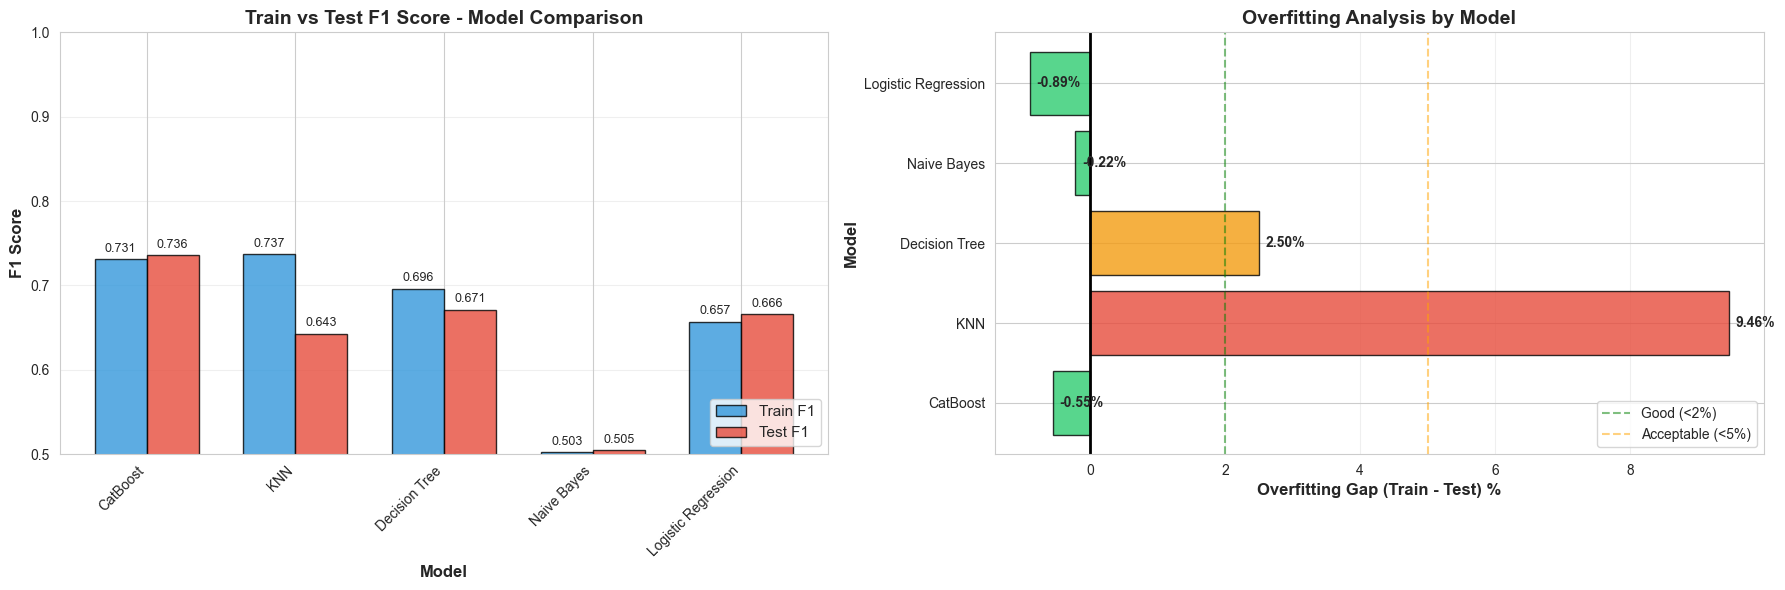


MODEL COMPARISON SUMMARY (F1 SCORE)
              Model  Train F1  Test F1       Gap     Gap %
           CatBoost  0.730832 0.736309 -0.005476 -0.749342
                KNN  0.737306 0.642716  0.094591 12.829231
      Decision Tree  0.696214 0.671208  0.025007  3.591794
        Naive Bayes  0.502636 0.504791 -0.002155 -0.428754
Logistic Regression  0.657094 0.665972 -0.008878 -1.351090

RANKING BY TEST F1 SCORE:
1. CatBoost             - Test F1: 0.7363 | Gap: -0.55%
2. Decision Tree        - Test F1: 0.6712 | Gap: 2.50%
3. Logistic Regression  - Test F1: 0.6660 | Gap: -0.89%
4. KNN                  - Test F1: 0.6427 | Gap: 9.46%
5. Naive Bayes          - Test F1: 0.5048 | Gap: -0.22%


In [11]:
# Visualize multi-model comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Train vs Test F1 Score for all models
x = np.arange(len(models_df))
width = 0.35

bars1 = axes[0].bar(x - width/2, models_df['Train F1'], width,
                    label='Train F1', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = axes[0].bar(x + width/2, models_df['Test F1'], width,
                    label='Test F1', color='#e74c3c', edgecolor='black', alpha=0.8)

axes[0].set_xlabel('Model', fontweight='bold', fontsize=12)
axes[0].set_ylabel('F1 Score', fontweight='bold', fontsize=12)
axes[0].set_title('Train vs Test F1 Score - Model Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_df['Model'], rotation=45, ha='right')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.50, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Right plot: Overfitting Gap (Train - Test)
colors_gap = []
for gap in models_df['Gap']:
    if gap < 0.02:
        colors_gap.append('#2ecc71')  # Green - good
    elif gap < 0.05:
        colors_gap.append('#f39c12')  # Orange - acceptable
    else:
        colors_gap.append('#e74c3c')  # Red - overfitting

bars = axes[1].barh(models_df['Model'], models_df['Gap'] * 100,
                     color=colors_gap, edgecolor='black', alpha=0.8)
axes[1].axvline(x=0, color='black', linewidth=2)
axes[1].axvline(x=2, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Good (<2%)')
axes[1].axvline(x=5, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Acceptable (<5%)')
axes[1].set_xlabel('Overfitting Gap (Train - Test) %', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Model', fontweight='bold', fontsize=12)
axes[1].set_title('Overfitting Analysis by Model', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].legend(loc='lower right', fontsize=10)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, models_df['Gap'] * 100)):
    axes[1].text(val + 0.1, bar.get_y() + bar.get_height()/2.,
                f'{val:.2f}%', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY (F1 SCORE)")
print("=" * 80)
print(models_df.to_string(index=False))
print("\n" + "=" * 80)
print("RANKING BY TEST F1 SCORE:")
print("=" * 80)
ranked = models_df.sort_values('Test F1', ascending=False).reset_index(drop=True)
for i, row in ranked.iterrows():
    print(f"{i+1}. {row['Model']:20s} - Test F1: {row['Test F1']:.4f} | Gap: {row['Gap']*100:.2f}%")
print("=" * 80)

## 7.1. Multi-Model Accuracy Comparison (Overfitting Analysis)

NameError: name 'comparison_df' is not defined

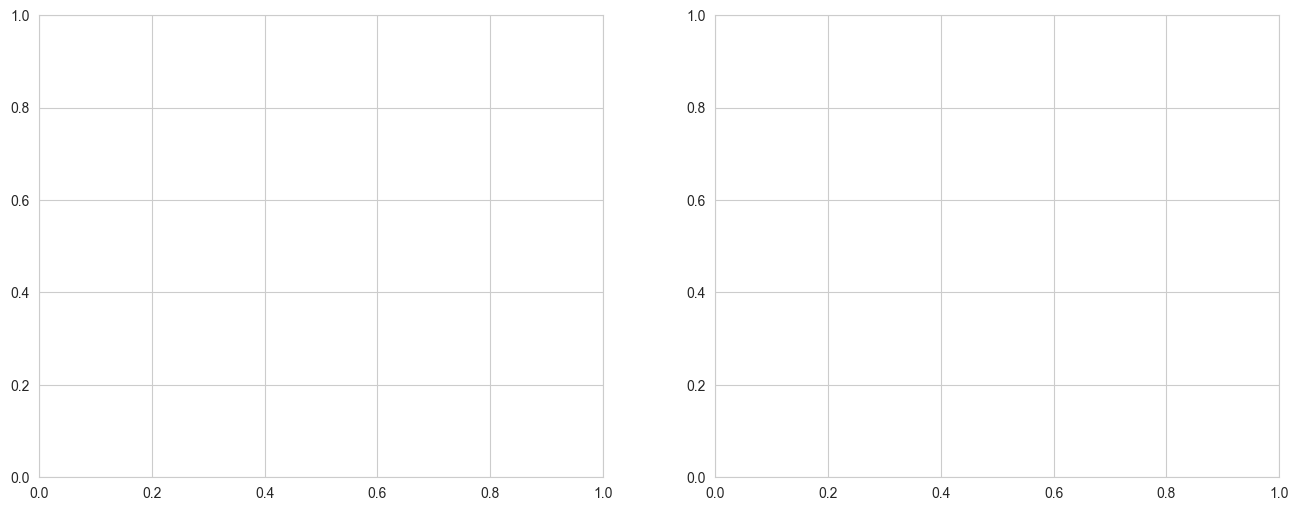

In [12]:
# Visualize Train vs Test comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparing all metrics
x = np.arange(len(comparison_df))
width = 0.35

bars1 = axes[0].bar(x - width/2, comparison_df['Train'], width, 
                    label='Train', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = axes[0].bar(x + width/2, comparison_df['Test'], width,
                    label='Test', color='#e74c3c', edgecolor='black', alpha=0.8)

axes[0].set_xlabel('Metric', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Train vs Test Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Metric'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Performance gap visualization
colors = ['#2ecc71' if gap < 0.02 else '#f39c12' if gap < 0.05 else '#e74c3c' 
          for gap in comparison_df['Difference'].abs()]

bars = axes[1].barh(comparison_df['Metric'], comparison_df['Difference'] * 100,
                     color=colors, edgecolor='black', alpha=0.8)
axes[1].axvline(x=0, color='black', linewidth=2)
axes[1].set_xlabel('Performance Gap (Train - Test) %', fontweight='bold')
axes[1].set_ylabel('Metric', fontweight='bold')
axes[1].set_title('Performance Gap by Metric', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, comparison_df['Difference'] * 100)):
    axes[1].text(val, bar.get_y() + bar.get_height()/2.,
                f'{val:.2f}%', ha='left' if val >= 0 else 'right',
                va='center', fontsize=10, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', edgecolor='black', label='Good (<2%)'),
    Patch(facecolor='#f39c12', edgecolor='black', label='Acceptable (2-5%)'),
    Patch(facecolor='#e74c3c', edgecolor='black', label='High (>5%)')
]
axes[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")

## 8. Confusion Matrix

CONFUSION MATRIX
----------------------------------------------------------------------
True Negatives:   6172 (Correctly predicted <=$50K)
False Positives:   495 (Incorrectly predicted >$50K)
False Negatives:   598 (Incorrectly predicted <=$50K)
True Positives:   1526 (Correctly predicted >$50K)

Total Errors: 1093 (12.43%)


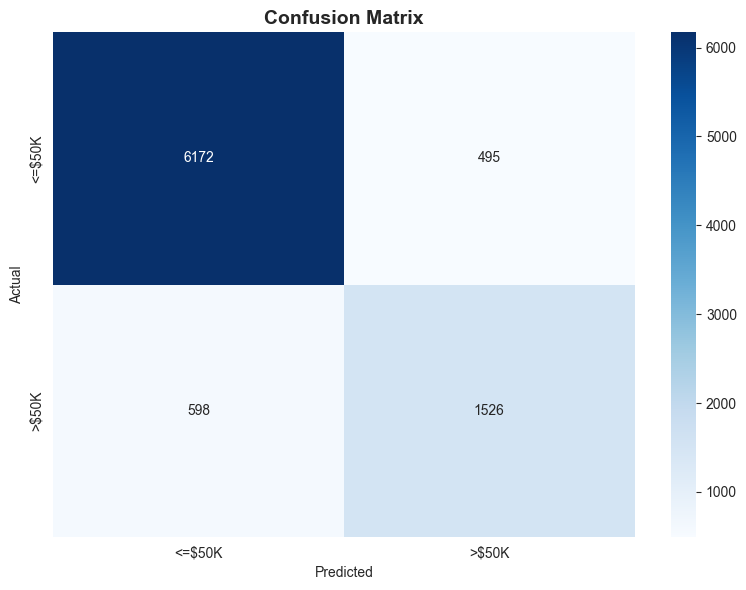

In [60]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("CONFUSION MATRIX")
print("-" * 70)
print(f"True Negatives:  {tn:5d} (Correctly predicted <=$50K)")
print(f"False Positives: {fp:5d} (Incorrectly predicted >$50K)")
print(f"False Negatives: {fn:5d} (Incorrectly predicted <=$50K)")
print(f"True Positives:  {tp:5d} (Correctly predicted >$50K)")
print()
print(f"Total Errors: {fp + fn} ({(fp+fn)/len(y_test)*100:.2f}%)")

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['<=$50K', '>$50K'],
            yticklabels=['<=$50K', '>$50K'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## 9. Classification Report

In [61]:
print("DETAILED CLASSIFICATION REPORT")
print("-" * 70)
print(classification_report(y_test, y_pred,
                          target_names=['Income <=$50K', 'Income >$50K']))

DETAILED CLASSIFICATION REPORT
----------------------------------------------------------------------
               precision    recall  f1-score   support

Income <=$50K       0.91      0.93      0.92      6667
 Income >$50K       0.76      0.72      0.74      2124

     accuracy                           0.88      8791
    macro avg       0.83      0.82      0.83      8791
 weighted avg       0.87      0.88      0.87      8791



## 10. ROC Curve Analysis

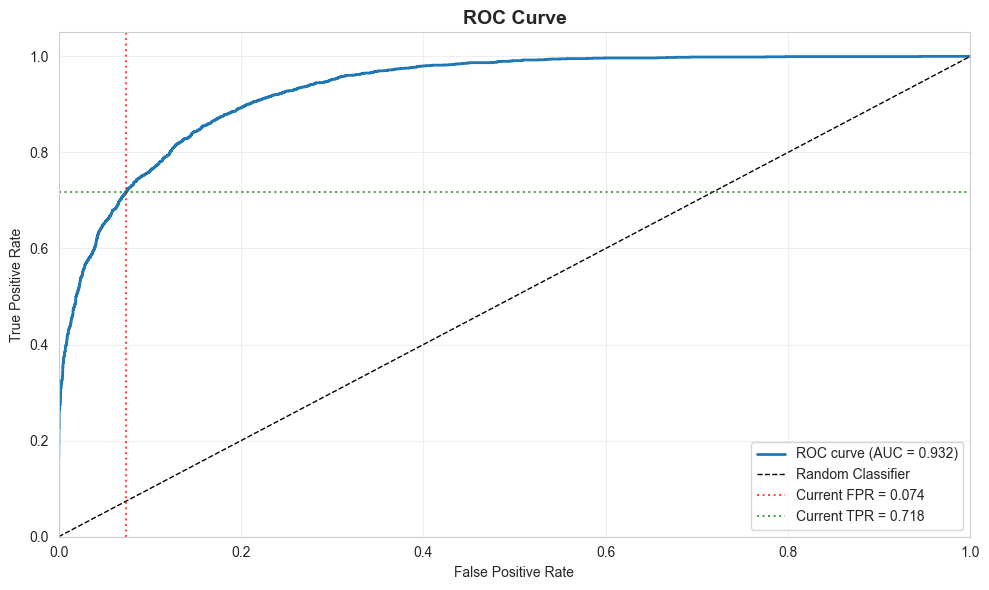

In [62]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.axvline(x=fp/(fp+tn), color='red', linestyle=':', alpha=0.7, label=f'Current FPR = {fp/(fp+tn):.3f}')
plt.axhline(y=tp/(tp+fn), color='green', linestyle=':', alpha=0.7, label=f'Current TPR = {tp/(tp+fn):.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Create Analysis DataFrame

In [63]:
# Create comprehensive analysis dataframe
test_df_analysis = test_df.copy()
test_df_analysis['predicted'] = y_pred
test_df_analysis['actual'] = y_test
test_df_analysis['probability'] = y_pred_proba
test_df_analysis['correct'] = (y_pred == y_test)
test_df_analysis['confidence'] = test_df_analysis.apply(
    lambda row: row['probability'] if row['predicted'] == 1 else 1 - row['probability'],
    axis=1
)

# Add prediction type
def get_prediction_type(row):
    if row['correct']:
        return 'True Negative' if row['actual'] == 0 else 'True Positive'
    else:
        return 'False Positive' if row['predicted'] == 1 else 'False Negative'

test_df_analysis['prediction_type'] = test_df_analysis.apply(get_prediction_type, axis=1)

print(f"Analysis dataframe created with {len(test_df_analysis)} rows")
print(f"\nPrediction type distribution:")
print(test_df_analysis['prediction_type'].value_counts())

test_df_analysis.head()

Analysis dataframe created with 8791 rows

Prediction type distribution:
prediction_type
True Negative     6172
True Positive     1526
False Negative     598
False Positive     495
Name: count, dtype: int64


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K,predicted,actual,probability,correct,confidence,prediction_type
35166,48,Private,76017,HS-grad,9,Widowed,Other-service,Unmarried,White,Female,0,0,25,United-States,0,0,0,0.007361,True,0.992639,True Negative
35167,41,Self-emp-not-inc,83411,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1,0,1,0.295384,False,0.704616,False Negative
35168,44,Private,230478,Assoc-acdm,12,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,1,0,1,0.283515,False,0.716485,False Negative
35169,42,Private,186689,HS-grad,9,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,60,United-States,0,0,0,0.083214,True,0.916786,True Negative
35170,23,Private,37514,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,55,United-States,0,0,0,0.013538,True,0.986462,True Negative


## 12. Error Analysis - False Positives

In [14]:
false_positives = test_df_analysis[test_df_analysis['prediction_type'] == 'False Positive']

print(f"FALSE POSITIVES: {len(false_positives)} cases")
print("(Model predicted >$50K but actual was <=$50K)")
print("=" * 70)

if len(false_positives) > 0:
    print(f"\nDemographic Characteristics:")
    print(f"  Average age: {false_positives['age'].mean():.1f} years")
    print(f"  Average education: {false_positives['educational-num'].mean():.1f} years")
    print(f"  Average hours/week: {false_positives['hours-per-week'].mean():.1f}")
    print(f"  Average capital gain: ${false_positives['capital-gain'].mean():.2f}")
    print(f"  Average capital loss: ${false_positives['capital-loss'].mean():.2f}")
    
    print(f"\nMost Common Characteristics:")
    print(f"  Gender: {false_positives['gender'].mode()[0] if len(false_positives) > 0 else 'N/A'}")
    print(f"  Education: {false_positives['education'].mode()[0] if len(false_positives) > 0 else 'N/A'}")
    print(f"  Occupation: {false_positives['occupation'].mode()[0] if len(false_positives) > 0 else 'N/A'}")
    print(f"  Marital Status: {false_positives['marital-status'].mode()[0] if len(false_positives) > 0 else 'N/A'}")
    
    print(f"\nTop 10 Occupations:")
    print(false_positives['occupation'].value_counts().head(10))
    
    # Show sample of false positives
    print(f"\nSample of False Positives:")
    display(false_positives[['age', 'education', 'occupation', 'hours-per-week', 
                             'gender', 'probability', 'confidence']].head(10))

NameError: name 'test_df_analysis' is not defined

## 13. Error Analysis - False Negatives

In [65]:
false_negatives = test_df_analysis[test_df_analysis['prediction_type'] == 'False Negative']

print(f"FALSE NEGATIVES: {len(false_negatives)} cases")
print("(Model predicted <=$50K but actual was >$50K)")
print("=" * 70)

if len(false_negatives) > 0:
    print(f"\nDemographic Characteristics:")
    print(f"  Average age: {false_negatives['age'].mean():.1f} years")
    print(f"  Average education: {false_negatives['educational-num'].mean():.1f} years")
    print(f"  Average hours/week: {false_negatives['hours-per-week'].mean():.1f}")
    print(f"  Average capital gain: ${false_negatives['capital-gain'].mean():.2f}")
    print(f"  Average capital loss: ${false_negatives['capital-loss'].mean():.2f}")
    
    print(f"\nMost Common Characteristics:")
    print(f"  Gender: {false_negatives['gender'].mode()[0] if len(false_negatives) > 0 else 'N/A'}")
    print(f"  Education: {false_negatives['education'].mode()[0] if len(false_negatives) > 0 else 'N/A'}")
    print(f"  Occupation: {false_negatives['occupation'].mode()[0] if len(false_negatives) > 0 else 'N/A'}")
    print(f"  Marital Status: {false_negatives['marital-status'].mode()[0] if len(false_negatives) > 0 else 'N/A'}")
    
    print(f"\nTop 10 Occupations:")
    print(false_negatives['occupation'].value_counts().head(10))
    
    # Show sample of false negatives
    print(f"\nSample of False Negatives:")
    display(false_negatives[['age', 'education', 'occupation', 'hours-per-week', 
                             'gender', 'probability', 'confidence']].head(10))

FALSE NEGATIVES: 598 cases
(Model predicted <=$50K but actual was >$50K)

Demographic Characteristics:
  Average age: 41.2 years
  Average education: 10.1 years
  Average hours/week: 44.7
  Average capital gain: $32.76
  Average capital loss: $14.41

Most Common Characteristics:
  Gender: Male
  Education: HS-grad
  Occupation: Craft-repair
  Marital Status: Married-civ-spouse

Top 10 Occupations:
occupation
Craft-repair         116
Sales                 82
Prof-specialty        67
Exec-managerial       60
Adm-clerical          57
Machine-op-inspct     51
Transport-moving      48
Handlers-cleaners     22
Other-service         22
Tech-support          21
Name: count, dtype: int64

Sample of False Negatives:


,age,education,occupation,hours-per-week,gender,probability,confidence
35167,41,HS-grad,Exec-managerial,40,Male,0.295384,0.704616
35168,44,Assoc-acdm,Exec-managerial,60,Male,0.283515,0.716485
35181,54,11th,Other-service,40,Female,0.201990,0.798010
35188,29,HS-grad,Craft-repair,40,Male,0.192935,0.807065
35203,41,Some-college,Transport-moving,48,Male,0.262268,0.737732
35207,40,HS-grad,Craft-repair,50,Male,0.222604,0.777396
35210,61,7th-8th,NaN,40,Male,0.136954,0.863046
35227,46,Assoc-voc,Farming-fishing,48,Male,0.382282,0.617718
35252,48,HS-grad,Craft-repair,40,Male,0.294423,0.705577
35254,33,Some-college,Craft-repair,40,Male,0.213450,0.786550


## 14. Error Rate by Demographics

In [66]:
print("ERROR RATE BY DEMOGRAPHICS")
print("=" * 70)

# By Gender
print("\nBy Gender:")
gender_stats = test_df_analysis.groupby('gender').agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})
print(gender_stats)

# By Age Group
print("\nBy Age Group:")
test_df_analysis['age_group'] = pd.cut(test_df_analysis['age'],
                                        bins=[0, 25, 35, 45, 55, 100],
                                        labels=['18-25', '26-35', '36-45', '46-55', '56+'])
age_stats = test_df_analysis.groupby('age_group', observed=True).agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})
print(age_stats)

# By Education
print("\nBy Education (Top 10 by error rate):")
education_stats = test_df_analysis.groupby('education').agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})
print(education_stats.sort_values('error_rate_%', ascending=False).head(10))

# By Occupation
print("\nBy Occupation (Top 10 by error rate, min 50 samples):")
occupation_stats = test_df_analysis.groupby('occupation').agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})
occupation_stats = occupation_stats[occupation_stats['count'] >= 50]
print(occupation_stats.sort_values('error_rate_%', ascending=False).head(10))

ERROR RATE BY DEMOGRAPHICS

By Gender:
        error_rate_%  count
gender                     
Female      5.246914   2916
Male       16.000000   5875

By Age Group:
           error_rate_%  count
age_group                     
18-25          1.265823   1659
26-35         11.376994   2382
36-45         16.318962   2157
46-55         19.769022   1472
56+           14.094558   1121

By Education (Top 10 by error rate):
              error_rate_%  count
education                        
Masters          17.943107    457
Bachelors        16.408877   1487
Assoc-voc        14.705882    374
Some-college     13.506626   1962
Doctorate        12.500000    112
Assoc-acdm       11.724138    290
HS-grad          11.685073   2807
Prof-school       9.027778    144
7th-8th           7.262570    179
10th              5.857741    239

By Occupation (Top 10 by error rate, min 50 samples):
                   error_rate_%  count
occupation                            
Protective-serv       23.204420    181

## 15. Confidence Analysis

PREDICTION CONFIDENCE ANALYSIS
Average confidence on correct predictions: 89.32%
Average confidence on incorrect predictions: 68.24%

Low confidence predictions (<60%):
  Total: 809 (9.20% of all predictions)
  Accuracy: 57.11%

High confidence predictions (>90%):
  Total: 5104 (58.06% of all predictions)
  Accuracy: 98.32%


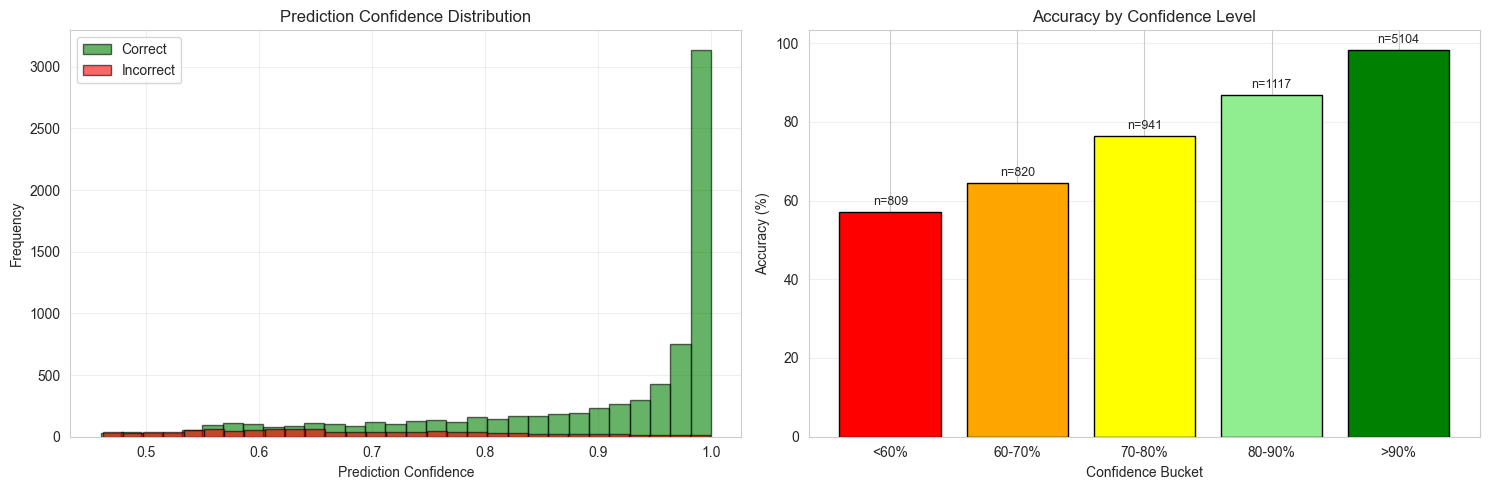

In [67]:
print("PREDICTION CONFIDENCE ANALYSIS")
print("=" * 70)

correct_confidence = test_df_analysis[test_df_analysis['correct'] == True]['confidence'].mean()
incorrect_confidence = test_df_analysis[test_df_analysis['correct'] == False]['confidence'].mean()

print(f"Average confidence on correct predictions: {correct_confidence*100:.2f}%")
print(f"Average confidence on incorrect predictions: {incorrect_confidence*100:.2f}%")

# Low confidence predictions
low_confidence = test_df_analysis[test_df_analysis['confidence'] < 0.6]
print(f"\nLow confidence predictions (<60%):")
print(f"  Total: {len(low_confidence)} ({len(low_confidence)/len(test_df_analysis)*100:.2f}% of all predictions)")
print(f"  Accuracy: {low_confidence['correct'].mean()*100:.2f}%")

# High confidence predictions
high_confidence = test_df_analysis[test_df_analysis['confidence'] > 0.9]
print(f"\nHigh confidence predictions (>90%):")
print(f"  Total: {len(high_confidence)} ({len(high_confidence)/len(test_df_analysis)*100:.2f}% of all predictions)")
print(f"  Accuracy: {high_confidence['correct'].mean()*100:.2f}%")

# Confidence distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
correct_conf = test_df_analysis[test_df_analysis['correct'] == True]['confidence']
incorrect_conf = test_df_analysis[test_df_analysis['correct'] == False]['confidence']

axes[0].hist(correct_conf, bins=30, alpha=0.6, label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_conf, bins=30, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Prediction Confidence')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy by confidence bucket
test_df_analysis['confidence_bucket'] = pd.cut(test_df_analysis['confidence'],
                                                bins=[0, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                labels=['<60%', '60-70%', '70-80%', '80-90%', '>90%'])
conf_accuracy = test_df_analysis.groupby('confidence_bucket', observed=True)['correct'].agg(['mean', 'count'])
conf_accuracy['mean'] *= 100

bars = axes[1].bar(range(len(conf_accuracy)), conf_accuracy['mean'], 
                   color=['red', 'orange', 'yellow', 'lightgreen', 'green'],
                   edgecolor='black')
axes[1].set_xticks(range(len(conf_accuracy)))
axes[1].set_xticklabels(conf_accuracy.index)
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_xlabel('Confidence Bucket')
axes[1].set_title('Accuracy by Confidence Level')
axes[1].grid(True, alpha=0.3, axis='y')

# Add count labels
for i, (bar, count) in enumerate(zip(bars, conf_accuracy['count'])):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'n={count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 16. Visualization: Error Rate by Demographics

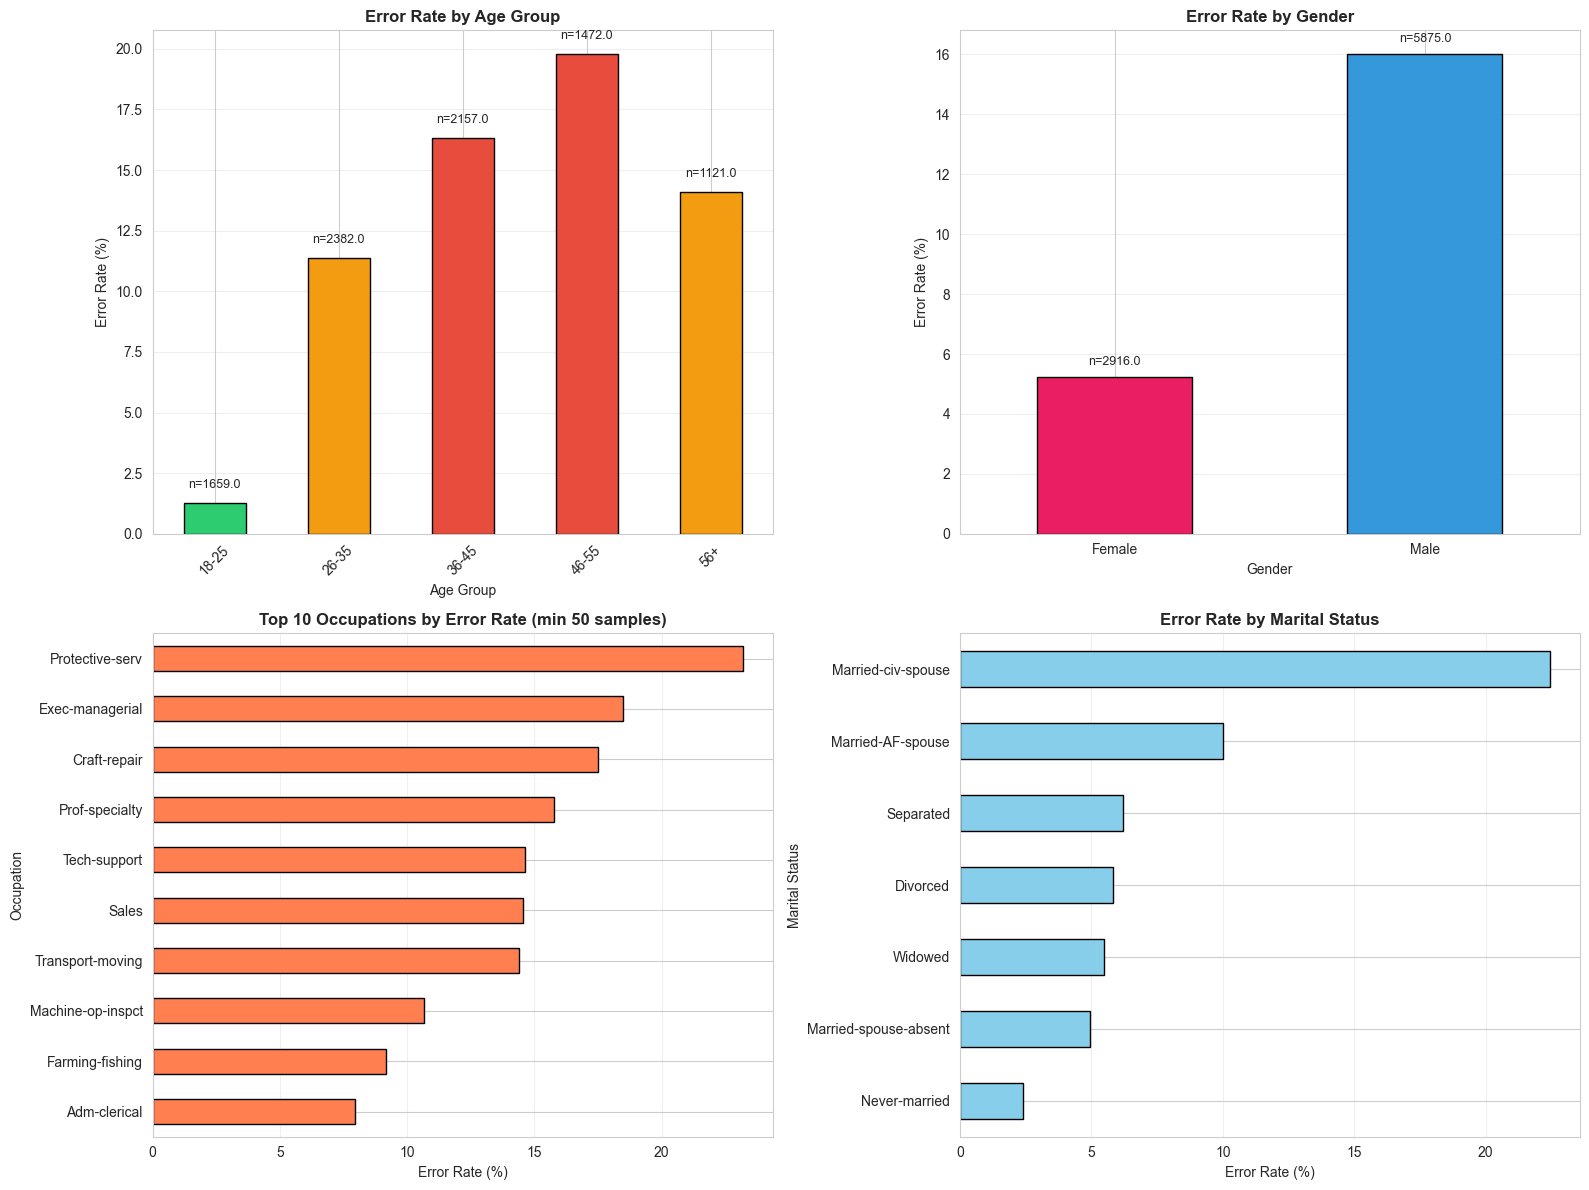

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Error Rate by Age Group
age_stats['error_rate_%'].plot(kind='bar', ax=axes[0, 0], 
                                color=['#2ecc71', '#f39c12', '#e74c3c', '#e74c3c', '#f39c12'],
                                edgecolor='black')
axes[0, 0].set_title('Error Rate by Age Group', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Error Rate (%)')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# Add count labels
for i, (idx, row) in enumerate(age_stats.iterrows()):
    axes[0, 0].text(i, row['error_rate_%'] + 0.5, f"n={row['count']}",
                    ha='center', va='bottom', fontsize=9)

# 2. Error Rate by Gender
gender_stats['error_rate_%'].plot(kind='bar', ax=axes[0, 1],
                                   color=['#e91e63', '#3498db'],
                                   edgecolor='black')
axes[0, 1].set_title('Error Rate by Gender', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Error Rate (%)')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=0)

for i, (idx, row) in enumerate(gender_stats.iterrows()):
    axes[0, 1].text(i, row['error_rate_%'] + 0.3, f"n={row['count']}",
                    ha='center', va='bottom', fontsize=9)

# 3. Top 10 Occupations by Error Rate
top_occ_errors = occupation_stats[occupation_stats['count'] >= 50].sort_values(
    'error_rate_%', ascending=True).tail(10)
top_occ_errors['error_rate_%'].plot(kind='barh', ax=axes[1, 0],
                                     color='coral', edgecolor='black')
axes[1, 0].set_title('Top 10 Occupations by Error Rate (min 50 samples)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Error Rate (%)')
axes[1, 0].set_ylabel('Occupation')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Error Rate by Marital Status
marital_stats = test_df_analysis.groupby('marital-status').agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})
marital_stats = marital_stats.sort_values('error_rate_%', ascending=True)

marital_stats['error_rate_%'].plot(kind='barh', ax=axes[1, 1],
                                    color='skyblue', edgecolor='black')
axes[1, 1].set_title('Error Rate by Marital Status', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Error Rate (%)')
axes[1, 1].set_ylabel('Marital Status')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 17. Error Rate by Feature Combinations

Analyzing mistake rates across combinations of demographic features to identify specific groups where the model performs poorly.

In [ ]:
### 17.1. Age Group + Gender Combinations

print("ERROR RATE BY AGE GROUP + GENDER COMBINATIONS")
print("=" * 70)

# Calculate error rates for age group + gender combinations
age_gender_combo = test_df_analysis.groupby(['age_group', 'gender'], observed=True).agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})

# Reset index for easier manipulation
age_gender_combo_reset = age_gender_combo.reset_index()

# Filter for combinations with at least 30 samples
age_gender_combo_filtered = age_gender_combo_reset[age_gender_combo_reset['count'] >= 30]

# Sort by error rate
age_gender_combo_sorted = age_gender_combo_filtered.sort_values('error_rate_%', ascending=False)

print("\nTop 15 Most Error-Prone Age+Gender Combinations (min 30 samples):")
print(age_gender_combo_sorted.head(15).to_string(index=False))

print(f"\n\nComplete Age Group + Gender Error Rates:")
age_gender_pivot = age_gender_combo.reset_index().pivot(index='age_group', columns='gender', values='error_rate_%')
print(age_gender_pivot)

print(f"\n\nComplete Age Group + Gender Counts:")
age_gender_count_pivot = age_gender_combo.reset_index().pivot(index='age_group', columns='gender', values='count')
print(age_gender_count_pivot)

In [ ]:
### 17.2. Marital Status + Gender Combinations

print("\nERROR RATE BY MARITAL STATUS + GENDER COMBINATIONS")
print("=" * 70)

# Calculate error rates for marital status + gender combinations
marital_gender_combo = test_df_analysis.groupby(['marital-status', 'gender']).agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})

# Reset index for easier manipulation
marital_gender_combo_reset = marital_gender_combo.reset_index()

# Filter for combinations with at least 30 samples
marital_gender_combo_filtered = marital_gender_combo_reset[marital_gender_combo_reset['count'] >= 30]

# Sort by error rate
marital_gender_combo_sorted = marital_gender_combo_filtered.sort_values('error_rate_%', ascending=False)

print("\nTop 15 Most Error-Prone Marital+Gender Combinations (min 30 samples):")
print(marital_gender_combo_sorted.head(15).to_string(index=False))

print(f"\n\nComplete Marital Status + Gender Error Rates:")
marital_gender_pivot = marital_gender_combo.reset_index().pivot(index='marital-status', columns='gender', values='error_rate_%')
print(marital_gender_pivot)

print(f"\n\nComplete Marital Status + Gender Counts:")
marital_gender_count_pivot = marital_gender_combo.reset_index().pivot(index='marital-status', columns='gender', values='count')
print(marital_gender_count_pivot)

In [ ]:
### 17.7. Summary: Top Error-Prone Demographic Combinations

print("=" * 80)
print("COMPREHENSIVE SUMMARY: TOP ERROR-PRONE DEMOGRAPHIC COMBINATIONS")
print("=" * 80)

# Create a comprehensive summary table combining all analyses
summary_data = []

# Add top 2-feature combinations
print("\nTOP 10 TWO-FEATURE COMBINATIONS:")
print("-" * 80)

# Age + Gender
for idx, row in age_gender_combo_sorted.head(5).iterrows():
    summary_data.append({
        'Type': '2-Feature',
        'Combination': f"{row['age_group']} + {row['gender']}",
        'Error Rate (%)': row['error_rate_%'],
        'Sample Size': row['count']
    })

# Marital + Gender
for idx, row in marital_gender_combo_sorted.head(5).iterrows():
    summary_data.append({
        'Type': '2-Feature',
        'Combination': f"{row['marital-status']} + {row['gender']}",
        'Error Rate (%)': row['error_rate_%'],
        'Sample Size': row['count']
    })

# Create DataFrame and display
summary_df_2 = pd.DataFrame([d for d in summary_data if d['Type'] == '2-Feature'])
summary_df_2 = summary_df_2.sort_values('Error Rate (%)', ascending=False).head(10).reset_index(drop=True)
print(summary_df_2.to_string(index=True))

print("\n\nTOP 15 THREE-FEATURE COMBINATIONS:")
print("-" * 80)

# Add top 3-feature combinations
summary_data_3 = []
for idx, row in three_feature_combo_sorted.head(15).iterrows():
    summary_data_3.append({
        'Age Group': row['age_group'],
        'Gender': row['gender'],
        'Marital Status': row['marital-status'],
        'Error Rate (%)': row['error_rate_%'],
        'Sample Size': row['count']
    })

summary_df_3 = pd.DataFrame(summary_data_3)
print(summary_df_3.to_string(index=True))

# Key insights
print("\n\n" + "=" * 80)
print("KEY INSIGHTS FROM FEATURE COMBINATIONS")
print("=" * 80)

# Calculate some key statistics
overall_male_error = test_df_analysis[test_df_analysis['gender'] == 'Male']['correct'].apply(lambda x: not x).mean() * 100
overall_female_error = test_df_analysis[test_df_analysis['gender'] == 'Female']['correct'].apply(lambda x: not x).mean() * 100

highest_2_combo = summary_df_2.iloc[0]
highest_3_combo = summary_df_3.iloc[0]

print(f"\n1. GENDER DISPARITY:")
print(f"   - Male overall error rate: {overall_male_error:.2f}%")
print(f"   - Female overall error rate: {overall_female_error:.2f}%")
print(f"   - Gender gap: {overall_male_error - overall_female_error:.2f} percentage points")

print(f"\n2. HIGHEST RISK 2-FEATURE COMBINATION:")
print(f"   - Combination: {highest_2_combo['Combination']}")
print(f"   - Error Rate: {highest_2_combo['Error Rate (%)']:.2f}%")
print(f"   - Sample Size: {highest_2_combo['Sample Size']}")

print(f"\n3. HIGHEST RISK 3-FEATURE COMBINATION:")
print(f"   - Group: {highest_3_combo['Age Group']} / {highest_3_combo['Gender']} / {highest_3_combo['Marital Status']}")
print(f"   - Error Rate: {highest_3_combo['Error Rate (%)']:.2f}%")
print(f"   - Sample Size: {highest_3_combo['Sample Size']}")

print(f"\n4. AGE-RELATED PATTERNS:")
age_46_55_error = test_df_analysis[test_df_analysis['age_group'] == '46-55']['correct'].apply(lambda x: not x).mean() * 100
age_18_25_error = test_df_analysis[test_df_analysis['age_group'] == '18-25']['correct'].apply(lambda x: not x).mean() * 100
print(f"   - Age 46-55 error rate: {age_46_55_error:.2f}%")
print(f"   - Age 18-25 error rate: {age_18_25_error:.2f}%")
print(f"   - Age gap: {age_46_55_error - age_18_25_error:.2f} percentage points")

print(f"\n5. MARITAL STATUS PATTERNS:")
married_error = test_df_analysis[test_df_analysis['marital-status'] == 'Married-civ-spouse']['correct'].apply(lambda x: not x).mean() * 100
never_married_error = test_df_analysis[test_df_analysis['marital-status'] == 'Never-married']['correct'].apply(lambda x: not x).mean() * 100
print(f"   - Married (civ-spouse) error rate: {married_error:.2f}%")
print(f"   - Never married error rate: {never_married_error:.2f}%")
print(f"   - Marital status gap: {married_error - never_married_error:.2f} percentage points")

print("\n" + "=" * 80)
print("FEATURE COMBINATION ANALYSIS COMPLETE!")
print("=" * 80)

In [ ]:
### 17.6. Visualizations - 3-Feature Combinations

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Top 15 three-feature combinations
ax1 = axes[0, 0]
top_15_three = three_feature_combo_sorted.head(15).copy()
top_15_three['combination'] = (top_15_three['age_group'].astype(str) + ' / ' +
                                 top_15_three['gender'] + ' / ' +
                                 top_15_three['marital-status'].str[:12])  # Truncate marital status

y_pos = range(len(top_15_three))
bars = ax1.barh(y_pos, top_15_three['error_rate_%'], color='darkred', edgecolor='black', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_15_three['combination'], fontsize=9)
ax1.set_xlabel('Error Rate (%)', fontweight='bold')
ax1.set_title('Top 15: Age+Gender+Marital Combinations', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_15_three.iterrows()):
    ax1.text(row['error_rate_%'] + 0.5, i,
             f"{row['error_rate_%']:.1f}% (n={row['count']})",
             va='center', fontsize=8)

# 2. Married men across age groups
ax2 = axes[0, 1]
married_men_filtered = married_men[married_men['count'] >= 10]
ax2.bar(range(len(married_men_filtered)), married_men_filtered['error_rate_%'],
        color='steelblue', edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(married_men_filtered)))
ax2.set_xticklabels(married_men_filtered['age_group'], rotation=45)
ax2.set_xlabel('Age Group', fontweight='bold')
ax2.set_ylabel('Error Rate (%)', fontweight='bold')
ax2.set_title('Married Men: Error Rate by Age', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(married_men_filtered.iterrows()):
    ax2.text(i, row['error_rate_%'] + 0.5,
             f"{row['error_rate_%']:.1f}%\n(n={row['count']})",
             ha='center', va='bottom', fontsize=9)

# 3. Grouped bar chart: Never Married vs Married-civ-spouse by age
ax3 = axes[1, 0]
never_married_by_age = three_feature_combo_reset[
    (three_feature_combo_reset['marital-status'] == 'Never-married') &
    (three_feature_combo_reset['count'] >= 20)
].groupby('age_group')['error_rate_%'].mean().sort_index()

married_by_age = three_feature_combo_reset[
    (three_feature_combo_reset['marital-status'] == 'Married-civ-spouse') &
    (three_feature_combo_reset['count'] >= 20)
].groupby('age_group')['error_rate_%'].mean().sort_index()

x = np.arange(len(never_married_by_age.index))
width = 0.35

ax3.bar(x - width/2, never_married_by_age.values, width,
        label='Never Married', color='orange', edgecolor='black', alpha=0.8)
ax3.bar(x + width/2, married_by_age.values, width,
        label='Married', color='purple', edgecolor='black', alpha=0.8)

ax3.set_xlabel('Age Group', fontweight='bold')
ax3.set_ylabel('Error Rate (%)', fontweight='bold')
ax3.set_title('Never Married vs Married: Error Rate by Age', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(never_married_by_age.index, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Error rate distribution for different marital statuses
ax4 = axes[1, 1]
marital_status_list = ['Never-married', 'Married-civ-spouse', 'Divorced', 'Separated', 'Widowed']
marital_error_rates = []
marital_colors = ['orange', 'purple', 'red', 'brown', 'gray']

for marital in marital_status_list:
    subset = three_feature_combo_reset[
        (three_feature_combo_reset['marital-status'] == marital) &
        (three_feature_combo_reset['count'] >= 10)
    ]
    if len(subset) > 0:
        marital_error_rates.append(subset['error_rate_%'].mean())
    else:
        marital_error_rates.append(0)

bars = ax4.bar(range(len(marital_status_list)), marital_error_rates,
               color=marital_colors, edgecolor='black', alpha=0.8)
ax4.set_xticks(range(len(marital_status_list)))
ax4.set_xticklabels([m.replace('-', '\n') for m in marital_status_list], fontsize=9)
ax4.set_ylabel('Average Error Rate (%)', fontweight='bold')
ax4.set_title('Average Error Rate by Marital Status', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, val in enumerate(marital_error_rates):
    ax4.text(i, val + 0.3, f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
### 17.5. Three-Feature Combinations (Age + Gender + Marital Status)

print("\nERROR RATE BY AGE + GENDER + MARITAL STATUS COMBINATIONS")
print("=" * 70)

# Calculate error rates for 3-feature combinations
three_feature_combo = test_df_analysis.groupby(['age_group', 'gender', 'marital-status'], observed=True).agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})

# Reset index for easier manipulation
three_feature_combo_reset = three_feature_combo.reset_index()

# Filter for combinations with at least 20 samples (lower threshold for 3-feature combos)
three_feature_combo_filtered = three_feature_combo_reset[three_feature_combo_reset['count'] >= 20]

# Sort by error rate
three_feature_combo_sorted = three_feature_combo_filtered.sort_values('error_rate_%', ascending=False)

print("\nTop 20 Most Error-Prone 3-Feature Combinations (min 20 samples):")
print(three_feature_combo_sorted.head(20).to_string(index=False))

# Focus on specific high-risk combinations
print("\n\n" + "=" * 70)
print("SPECIFIC HIGH-RISK GROUPS")
print("=" * 70)

# Married men by age group
print("\n1. MARRIED MEN BY AGE GROUP:")
married_men = three_feature_combo_reset[
    (three_feature_combo_reset['gender'] == 'Male') &
    (three_feature_combo_reset['marital-status'] == 'Married-civ-spouse')
].sort_values('age_group')
print(married_men[['age_group', 'error_rate_%', 'count']].to_string(index=False))

# Divorced/Separated people by age and gender
print("\n2. DIVORCED/SEPARATED PEOPLE BY AGE AND GENDER:")
divorced = three_feature_combo_reset[
    three_feature_combo_reset['marital-status'].isin(['Divorced', 'Separated'])
].sort_values('error_rate_%', ascending=False).head(10)
print(divorced[['age_group', 'gender', 'marital-status', 'error_rate_%', 'count']].to_string(index=False))

# Never married by age and gender
print("\n3. NEVER MARRIED BY AGE AND GENDER:")
never_married = three_feature_combo_reset[
    three_feature_combo_reset['marital-status'] == 'Never-married'
].sort_values('error_rate_%', ascending=False).head(10)
print(never_married[['age_group', 'gender', 'error_rate_%', 'count']].to_string(index=False))

In [ ]:
### 17.4. Visualizations - 2-Feature Combinations

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Heatmap: Age Group vs Gender
ax1 = axes[0, 0]
age_gender_pivot_data = age_gender_pivot.fillna(0)
sns.heatmap(age_gender_pivot_data, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1,
            cbar_kws={'label': 'Error Rate (%)'}, vmin=0, vmax=30)
ax1.set_title('Error Rate: Age Group vs Gender', fontsize=14, fontweight='bold')
ax1.set_xlabel('Gender', fontweight='bold')
ax1.set_ylabel('Age Group', fontweight='bold')

# Add sample counts as text
for i, age_group in enumerate(age_gender_count_pivot.index):
    for j, gender in enumerate(age_gender_count_pivot.columns):
        count = age_gender_count_pivot.loc[age_group, gender]
        if pd.notna(count):
            ax1.text(j + 0.5, i + 0.7, f'n={int(count)}',
                     ha='center', va='center', fontsize=8, color='blue', alpha=0.7)

# 2. Heatmap: Marital Status vs Gender
ax2 = axes[0, 1]
marital_gender_pivot_data = marital_gender_pivot.fillna(0)
sns.heatmap(marital_gender_pivot_data, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2,
            cbar_kws={'label': 'Error Rate (%)'}, vmin=0, vmax=30)
ax2.set_title('Error Rate: Marital Status vs Gender', fontsize=14, fontweight='bold')
ax2.set_xlabel('Gender', fontweight='bold')
ax2.set_ylabel('Marital Status', fontweight='bold')

# Add sample counts
for i, marital in enumerate(marital_gender_count_pivot.index):
    for j, gender in enumerate(marital_gender_count_pivot.columns):
        count = marital_gender_count_pivot.loc[marital, gender]
        if pd.notna(count):
            ax2.text(j + 0.5, i + 0.7, f'n={int(count)}',
                     ha='center', va='center', fontsize=8, color='blue', alpha=0.7)

# 3. Bar chart: Top 10 Age+Gender combinations
ax3 = axes[1, 0]
top_age_gender = age_gender_combo_sorted.head(10).copy()
top_age_gender['combination'] = top_age_gender['age_group'].astype(str) + ' + ' + top_age_gender['gender']
ax3.barh(range(len(top_age_gender)), top_age_gender['error_rate_%'],
         color='coral', edgecolor='black')
ax3.set_yticks(range(len(top_age_gender)))
ax3.set_yticklabels(top_age_gender['combination'])
ax3.set_xlabel('Error Rate (%)', fontweight='bold')
ax3.set_title('Top 10: Age+Gender Combinations', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_age_gender.iterrows()):
    ax3.text(row['error_rate_%'] + 0.5, i,
             f"{row['error_rate_%']:.1f}% (n={row['count']})",
             va='center', fontsize=9)

# 4. Bar chart: Top 10 Marital+Gender combinations
ax4 = axes[1, 1]
top_marital_gender = marital_gender_combo_sorted.head(10).copy()
top_marital_gender['combination'] = top_marital_gender['marital-status'].astype(str) + ' + ' + top_marital_gender['gender']
ax4.barh(range(len(top_marital_gender)), top_marital_gender['error_rate_%'],
         color='skyblue', edgecolor='black')
ax4.set_yticks(range(len(top_marital_gender)))
ax4.set_yticklabels(top_marital_gender['combination'])
ax4.set_xlabel('Error Rate (%)', fontweight='bold')
ax4.set_title('Top 10: Marital+Gender Combinations', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_marital_gender.iterrows()):
    ax4.text(row['error_rate_%'] + 0.5, i,
             f"{row['error_rate_%']:.1f}% (n={row['count']})",
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
### 17.3. Age Group + Marital Status Combinations

print("\nERROR RATE BY AGE GROUP + MARITAL STATUS COMBINATIONS")
print("=" * 70)

# Calculate error rates for age group + marital status combinations
age_marital_combo = test_df_analysis.groupby(['age_group', 'marital-status'], observed=True).agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})

# Reset index for easier manipulation
age_marital_combo_reset = age_marital_combo.reset_index()

# Filter for combinations with at least 30 samples
age_marital_combo_filtered = age_marital_combo_reset[age_marital_combo_reset['count'] >= 30]

# Sort by error rate
age_marital_combo_sorted = age_marital_combo_filtered.sort_values('error_rate_%', ascending=False)

print("\nTop 15 Most Error-Prone Age+Marital Combinations (min 30 samples):")
print(age_marital_combo_sorted.head(15).to_string(index=False))

## 17. Visualization: Feature Analysis

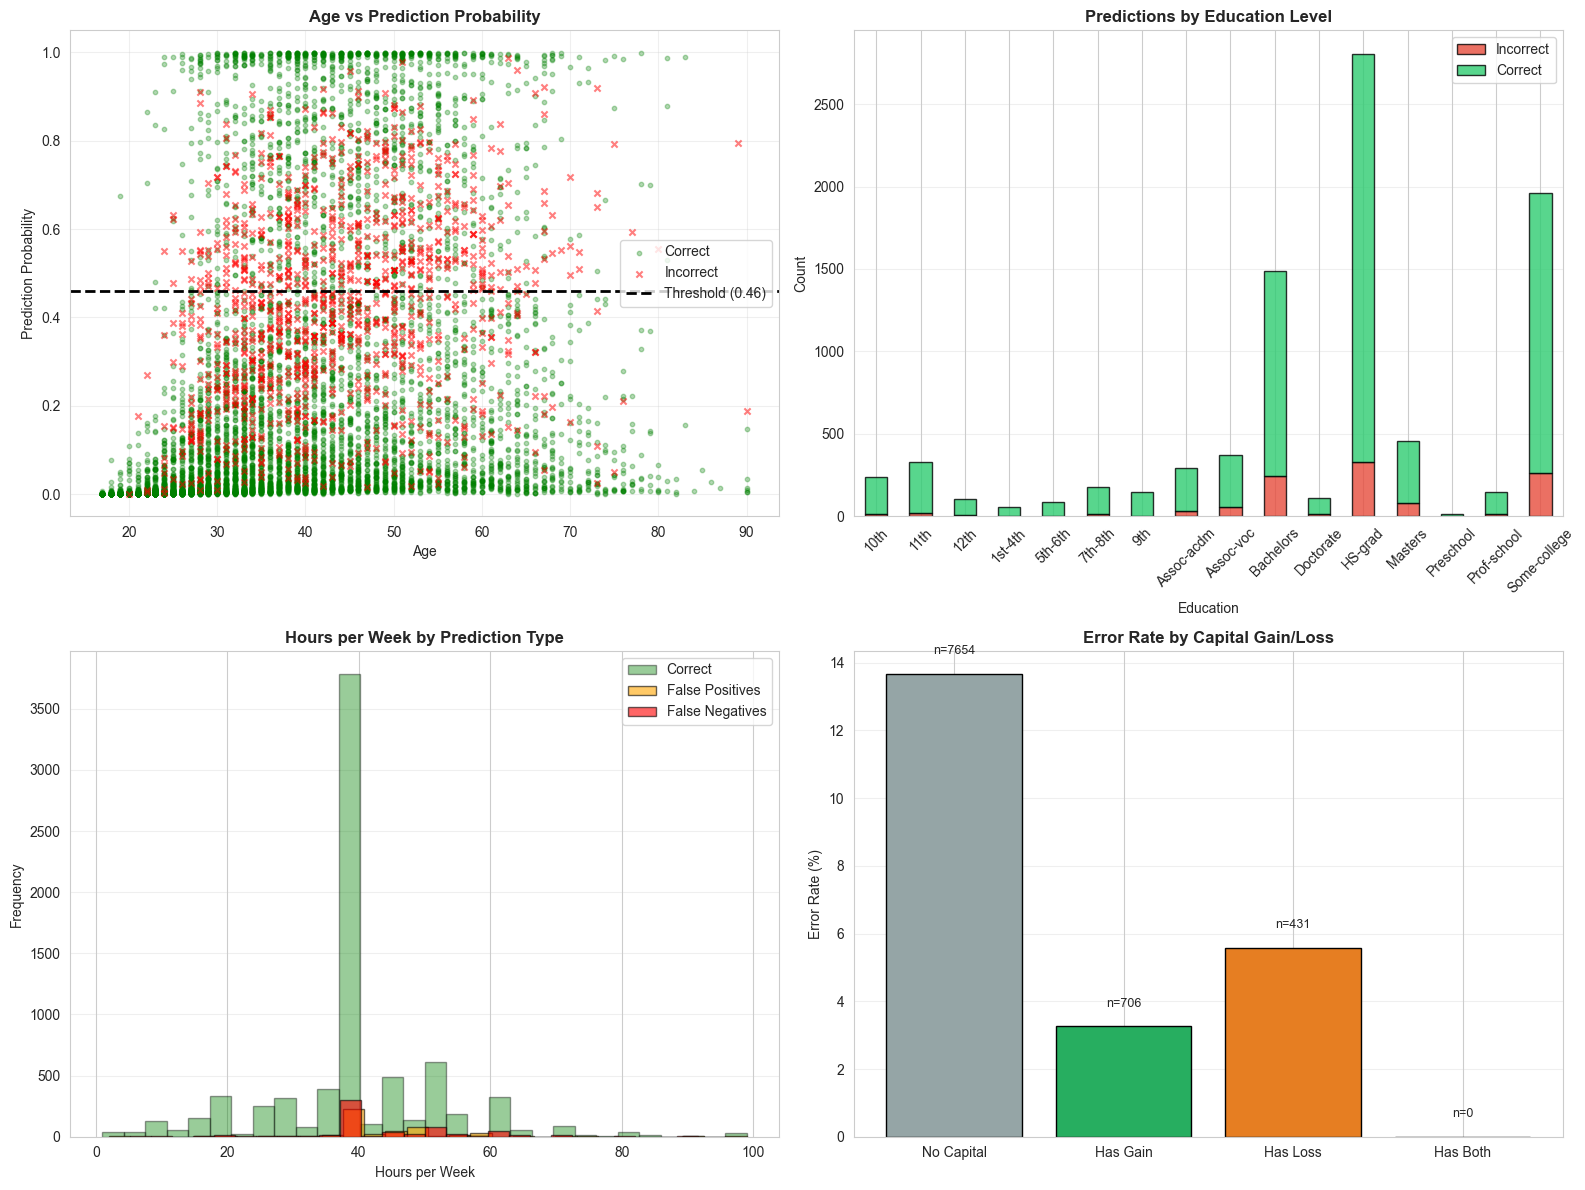

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Age vs Probability Scatter
correct_pred = test_df_analysis[test_df_analysis['correct'] == True]
incorrect_pred = test_df_analysis[test_df_analysis['correct'] == False]

axes[0, 0].scatter(correct_pred['age'], correct_pred['probability'],
                   alpha=0.3, s=10, c='green', label='Correct')
axes[0, 0].scatter(incorrect_pred['age'], incorrect_pred['probability'],
                   alpha=0.5, s=20, c='red', label='Incorrect', marker='x')
axes[0, 0].axhline(y=0.46, color='black', linestyle='--', linewidth=2, label='Threshold (0.46)')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Prediction Probability')
axes[0, 0].set_title('Age vs Prediction Probability', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Education vs Hours per Week
pivot_data = test_df_analysis.groupby(['education', 'correct']).size().unstack(fill_value=0)
pivot_data.plot(kind='bar', stacked=True, ax=axes[0, 1],
                color=['#e74c3c', '#2ecc71'], edgecolor='black', alpha=0.8)
axes[0, 1].set_title('Predictions by Education Level', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Education')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(['Incorrect', 'Correct'])
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Hours per Week Distribution
true_pred = test_df_analysis[test_df_analysis['correct'] == True]

axes[1, 0].hist(true_pred['hours-per-week'], bins=30, alpha=0.4,
                label='Correct', color='green', edgecolor='black')
axes[1, 0].hist(false_positives['hours-per-week'], bins=30, alpha=0.6,
                label='False Positives', color='orange', edgecolor='black')
axes[1, 0].hist(false_negatives['hours-per-week'], bins=30, alpha=0.6,
                label='False Negatives', color='red', edgecolor='black')
axes[1, 0].set_xlabel('Hours per Week')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Hours per Week by Prediction Type', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Capital Gain/Loss Analysis
has_capital_gain = test_df_analysis['capital-gain'] > 0
has_capital_loss = test_df_analysis['capital-loss'] > 0

capital_errors = []
capital_counts = []
labels = ['No Capital', 'Has Gain', 'Has Loss', 'Has Both']

for mask in [
    ~has_capital_gain & ~has_capital_loss,
    has_capital_gain & ~has_capital_loss,
    ~has_capital_gain & has_capital_loss,
    has_capital_gain & has_capital_loss
]:
    subset = test_df_analysis[mask]
    if len(subset) > 0:
        capital_errors.append((1 - subset['correct'].mean()) * 100)
        capital_counts.append(len(subset))
    else:
        capital_errors.append(0)
        capital_counts.append(0)

bars = axes[1, 1].bar(range(len(capital_errors)), capital_errors,
                      color=['#95a5a6', '#27ae60', '#e67e22', '#3498db'],
                      edgecolor='black')
axes[1, 1].set_xticks(range(len(labels)))
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_ylabel('Error Rate (%)')
axes[1, 1].set_title('Error Rate by Capital Gain/Loss', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, (bar, count) in enumerate(zip(bars, capital_counts)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'n={count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 18. Export Results

In [70]:
# Export errors to CSV
errors_df = test_df_analysis[test_df_analysis['correct'] == False].copy()
errors_df = errors_df.sort_values('probability', ascending=False)
errors_df.to_csv('../backend/model_errors_notebook.csv', index=False)
print(f"Saved {len(errors_df)} errors to 'backend/model_errors_notebook.csv'")

# Export all predictions
test_df_analysis.to_csv('../backend/test_predictions_notebook.csv', index=False)
print(f"Saved all {len(test_df_analysis)} predictions to 'backend/test_predictions_notebook.csv'")

print("\nExport complete!")

Saved 1093 errors to 'backend/model_errors_notebook.csv'
Saved all 8791 predictions to 'backend/test_predictions_notebook.csv'

Export complete!


## 19. Summary and Conclusions

In [71]:
print("=" * 70)
print("MODEL EVALUATION SUMMARY")
print("=" * 70)

print(f"\nOverall Performance:")
print(f"  • Accuracy:  {accuracy*100:.2f}%")
print(f"  • Precision: {precision*100:.2f}%")
print(f"  • Recall:    {recall*100:.2f}%")
print(f"  • F1 Score:  {f1:.4f}")
print(f"  • ROC-AUC:   {roc_auc:.4f}")

print(f"\nKey Findings:")
print(f"  • Total predictions: {len(y_test):,}")
print(f"  • Total errors: {fp + fn:,} ({(fp+fn)/len(y_test)*100:.2f}%)")
print(f"  • False positives: {fp:,}")
print(f"  • False negatives: {fn:,}")

print(f"\nError Patterns:")
print(f"  • Gender: Males have {gender_stats.loc['Male', 'error_rate_%']:.2f}% error vs Females {gender_stats.loc['Female', 'error_rate_%']:.2f}%")
print(f"  • Age: 46-55 year-olds have highest error rate at {age_stats.loc['46-55', 'error_rate_%']:.2f}%")
print(f"  • High confidence (>90%) predictions have {high_confidence['correct'].mean()*100:.2f}% accuracy")
print(f"  • Low confidence (<60%) predictions have {low_confidence['correct'].mean()*100:.2f}% accuracy")

print("\n" + "=" * 70)
print("EVALUATION COMPLETE!")
print("=" * 70)

MODEL EVALUATION SUMMARY

Overall Performance:
  • Accuracy:  87.57%
  • Precision: 75.51%
  • Recall:    71.85%
  • F1 Score:  0.7363
  • ROC-AUC:   0.9319

Key Findings:
  • Total predictions: 8,791
  • Total errors: 1,093 (12.43%)
  • False positives: 495
  • False negatives: 598

Error Patterns:
  • Gender: Males have 16.00% error vs Females 5.25%
  • Age: 46-55 year-olds have highest error rate at 19.77%
  • High confidence (>90%) predictions have 98.32% accuracy
  • Low confidence (<60%) predictions have 57.11% accuracy

EVALUATION COMPLETE!
